In [1]:
CWD = r'C:\Users\Evant\Desktop\cis472\latest\CIS472-CourseProject'
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import numpy as np
import sys
import time
import shutil
sys.path.append(CWD+r'\models')
# sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\models')
from lenet import LeNet
from vgg import VGG16
from alexnet import AlexNet
sys.path.pop()
# sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\training')
# from training import train_epoch, evaluate
# sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Qut Fish Dataset

In [3]:
# data_path = "C:\\Users\\hansm\\Github\\CIS472-CourseProject\\Project Datasets\\Dataset1\\QutFishDataset\\archive\\Fish_data"
data_path = r"C:\Users\Evant\Desktop\cis472\Fish_Data"

In [4]:
# get all classes for the dataset
classes = []
# classes_file = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset1\QutFishDataset\archive\Fish_data\final_all_index.txt"
classes_file = r"C:\Users\Evant\Desktop\cis472\Fish_Data\final_all_index.txt"
with open(classes_file) as classesf:
    for line in classesf:
        splitted_line = line.strip().split('=')
        cls = splitted_line[1]
        if cls not in classes:
            classes.append(cls)
        else:
            continue
    classesf.close()
num_classes = len(classes)
print(num_classes)

483


In [5]:
class QutFishDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.labels = []
        self.images = []
        index_file = f"{self.data_path}\\final_all_index.txt"
        with open(index_file) as indexf:
            for line in indexf:
                splitted_line = line.strip().split('=')
                label = splitted_line[0]
                image = splitted_line[4] + ".png"
                self.labels.append(label)
                self.images.append(image)
            indexf.close()
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img = Image.open(f"{self.data_path}\\images\\numbered\\{self.images[idx]}").convert("RGB")
        img = img.convert("RGB")
        img = self.transform(img)
        label = torch.tensor(int(self.labels[idx]) - 1)
        return img, label

<br><span style="color:black;font-size:35px">**LeNet**</span>

In [6]:
# lenet = LeNet(num_classes)
# lenetModel = lenet.to(device)
# print(lenetModel)

In [7]:
# hyperparameters
lenet_batch_size = 16
lenet_learning_rate=0.1
lenet_nepochs = 30

In [8]:
# transform
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
# Split dataset into train and test sets
fish_data = QutFishDataset(data_path=data_path, transform=transform)
train_size = int(0.8 * len(fish_data))
test_size = len(fish_data) - train_size
train_dataset, test_dataset = random_split(fish_data, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

3528
883


In [10]:
# train and test loader
train_loader = DataLoader(train_dataset, batch_size=lenet_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=lenet_batch_size, shuffle=False)
print(len(train_loader))

221


In [11]:
def evaluate(model, test_data):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for (data, label) in test_data:
#             print(data)
            data = data.to(device)
#             label = torch.tensor(label)
#             print(label)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
#             answers = torch.max(out, dim=1)
#             print(answers)
            accuracy += (answers == label).sum()
    return accuracy

In [12]:
def train_epoch(model, train_data, LossFunction, optimizer):
#     model.to(device)
    model.train()
    loss_history = []
    acc_history = []
    correct = 0
    for (data, label) in tqdm(train_data, desc="iteration", unit="%", disable=True):
        # clear the gradients
        optimizer.zero_grad(set_to_none=True)
        
        # send the data and labels to the same device as the training model
        data = data.to(device)
#         print(label.shape)
        label = label.to(device)

        # get the output from the model
        out = model(data)
#         print(out.shape)
        _, output = torch.max(out, 1)
        
        # calculate loss
        loss = LossFunction(out, label)
        
        # calculate gradients and perform gradient descent
        loss.backward()
        optimizer.step()
        correct += (output == label).float().sum()
        loss_history.append(loss.item())
    accuracy = 100 * correct / len(train_dataset)
    return loss_history, accuracy

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([16, 3, 32, 32]), torch.Size([16])
Labels: tensor([442, 224, 133,  93, 272,  97,  79, 171, 451, 402, 272, 415, 162, 279,
        149, 440])



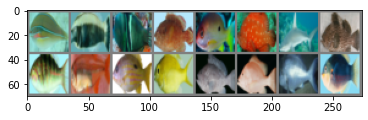

In [13]:
data = iter(train_loader) # iterate through data
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")
img_grid = make_grid(single_point[0])
matplotlib_imshow(img_grid)

In [66]:
lenet_1 = LeNet(num_classes=num_classes).to(device)

# Adam optimizer
lenet_optimizer_adam = optim.Adam(lenet_1.parameters(), lr=lenet_learning_rate)

# loss function
loss_function = nn.CrossEntropyLoss()

# for epoch in range(nepochs):
#     running_loss = 0.0
#     start_time = time.time()
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
#         optimizer.zero_grad()
        
#         output = lenetModel(inputs)
#         loss = LossFunction(output, labels)
#         loss.backward()
#         optimizer.step()
        
#         end_time = time.time()
#         elapsed_time = (end_time - start_time)/60
#         running_loss += loss.item()
#         if (i+1) % 20 == 0:
#             print('[epoch: %d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
#             print(f"Time: {elapsed_time} min")
#             running_loss = 0.0
#     print()
lenet_1.train()
lenet_loss_history_1 = []
lenet_train_acc_history_1 = []
lenet_test_acc_history_1 = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=lenet_1, 
                                          train_data=train_loader, 
                                          LossFunction=loss_function, 
                                          optimizer=lenet_optimizer_adam))
    lenet_loss_history_1.append(loss_history)
    lenet_train_acc_history_1.append(accuracy)
    lenet_test_acc_history_1.append((evaluate(lenet_1, test_loader) / len(test_dataset)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {lenet_loss_history_1[-1][-1]}"
          f"\ntrain acc:  {float(lenet_train_acc_history_1[-1])} test acc: {float(lenet_test_acc_history_1[-1])}")

Epoch:   3%|██▍                                                                      | 1/30 [00:11<05:38, 11.67s/epoch]

Epoch 0:
train loss: 6.301864147186279
train acc:  0.7086167931556702 test acc: 0.7927519083023071


Epoch:   7%|████▊                                                                    | 2/30 [00:23<05:24, 11.61s/epoch]

Epoch 1:
train loss: 6.068131446838379
train acc:  1.1621315479278564 test acc: 1.2457530498504639


Epoch:  10%|███████▎                                                                 | 3/30 [00:34<05:14, 11.64s/epoch]

Epoch 2:
train loss: 5.959287166595459
train acc:  2.8344671726226807 test acc: 2.6047565937042236


Epoch:  13%|█████████▋                                                               | 4/30 [00:46<05:01, 11.61s/epoch]

Epoch 3:
train loss: 5.495223522186279
train acc:  5.470521450042725 test acc: 4.530011177062988


Epoch:  17%|████████████▏                                                            | 5/30 [00:58<04:50, 11.64s/epoch]

Epoch 4:
train loss: 4.1809539794921875
train acc:  7.9365081787109375 test acc: 5.662513732910156


Epoch:  20%|██████████████▌                                                          | 6/30 [01:09<04:39, 11.63s/epoch]

Epoch 5:
train loss: 3.8796815872192383
train acc:  11.592970848083496 test acc: 7.587769031524658


Epoch:  23%|█████████████████                                                        | 7/30 [01:21<04:27, 11.61s/epoch]

Epoch 6:
train loss: 3.7421765327453613
train acc:  15.646258354187012 test acc: 9.739523887634277


Epoch:  27%|███████████████████▍                                                     | 8/30 [01:33<04:16, 11.64s/epoch]

Epoch 7:
train loss: 4.549192428588867
train acc:  20.011337280273438 test acc: 11.098526954650879


Epoch:  30%|█████████████████████▉                                                   | 9/30 [01:44<04:03, 11.60s/epoch]

Epoch 8:
train loss: 3.619709014892578
train acc:  27.267574310302734 test acc: 13.929784774780273


Epoch:  33%|████████████████████████                                                | 10/30 [01:56<03:52, 11.63s/epoch]

Epoch 9:
train loss: 2.737217903137207
train acc:  31.46258544921875 test acc: 13.47678279876709


Epoch:  37%|██████████████████████████▍                                             | 11/30 [02:08<03:43, 11.76s/epoch]

Epoch 10:
train loss: 2.312439203262329
train acc:  36.621315002441406 test acc: 13.363533020019531


Epoch:  40%|████████████████████████████▊                                           | 12/30 [02:20<03:33, 11.87s/epoch]

Epoch 11:
train loss: 3.0063493251800537
train acc:  42.403629302978516 test acc: 16.42129135131836


Epoch:  43%|███████████████████████████████▏                                        | 13/30 [02:32<03:21, 11.83s/epoch]

Epoch 12:
train loss: 1.0898349285125732
train acc:  48.32766342163086 test acc: 15.288787841796875


Epoch:  47%|█████████████████████████████████▌                                      | 14/30 [02:43<03:07, 11.75s/epoch]

Epoch 13:
train loss: 1.9664487838745117
train acc:  52.125850677490234 test acc: 16.534542083740234


Epoch:  50%|████████████████████████████████████                                    | 15/30 [02:55<02:55, 11.73s/epoch]

Epoch 14:
train loss: 1.8581092357635498
train acc:  58.64512634277344 test acc: 16.42129135131836


Epoch:  53%|██████████████████████████████████████▍                                 | 16/30 [03:07<02:43, 11.69s/epoch]

Epoch 15:
train loss: 1.2318679094314575
train acc:  63.4920654296875 test acc: 16.64779281616211


Epoch:  57%|████████████████████████████████████████▊                               | 17/30 [03:18<02:31, 11.66s/epoch]

Epoch 16:
train loss: 0.7980059385299683
train acc:  66.97846221923828 test acc: 17.100791931152344


Epoch:  60%|███████████████████████████████████████████▏                            | 18/30 [03:30<02:22, 11.84s/epoch]

Epoch 17:
train loss: 1.5948066711425781
train acc:  70.66326904296875 test acc: 16.42129135131836


Epoch:  63%|█████████████████████████████████████████████▌                          | 19/30 [03:42<02:10, 11.91s/epoch]

Epoch 18:
train loss: 0.9724603295326233
train acc:  74.09297180175781 test acc: 17.55379295349121


Epoch:  67%|████████████████████████████████████████████████                        | 20/30 [03:54<01:59, 11.90s/epoch]

Epoch 19:
train loss: 0.6783766746520996
train acc:  75.48185729980469 test acc: 18.006793975830078


Epoch:  70%|██████████████████████████████████████████████████▍                     | 21/30 [04:06<01:46, 11.83s/epoch]

Epoch 20:
train loss: 1.3504005670547485
train acc:  77.97618865966797 test acc: 17.55379295349121


Epoch:  73%|████████████████████████████████████████████████████▊                   | 22/30 [04:18<01:34, 11.77s/epoch]

Epoch 21:
train loss: 0.9682618379592896
train acc:  79.76190948486328 test acc: 19.36579704284668


Epoch:  77%|███████████████████████████████████████████████████████▏                | 23/30 [04:29<01:22, 11.77s/epoch]

Epoch 22:
train loss: 0.5639228820800781
train acc:  82.02947998046875 test acc: 18.233295440673828


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 24/30 [04:41<01:10, 11.74s/epoch]

Epoch 23:
train loss: 0.41576895117759705
train acc:  82.45465087890625 test acc: 18.686296463012695


Epoch:  83%|████████████████████████████████████████████████████████████            | 25/30 [04:53<00:58, 11.73s/epoch]

Epoch 24:
train loss: 2.4229302406311035
train acc:  83.02154541015625 test acc: 16.874292373657227


Epoch:  87%|██████████████████████████████████████████████████████████████▍         | 26/30 [05:05<00:46, 11.74s/epoch]

Epoch 25:
train loss: 0.3301945924758911
train acc:  84.01360321044922 test acc: 18.006793975830078


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [05:17<00:35, 11.82s/epoch]

Epoch 26:
train loss: 0.2591838240623474
train acc:  87.1882095336914 test acc: 16.874292373657227


Epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 28/30 [05:29<00:23, 12.00s/epoch]

Epoch 27:
train loss: 0.6080251336097717
train acc:  90.27777862548828 test acc: 19.252548217773438


Epoch:  97%|█████████████████████████████████████████████████████████████████████▌  | 29/30 [05:41<00:12, 12.00s/epoch]

Epoch 28:
train loss: 0.6852115988731384
train acc:  87.3299331665039 test acc: 18.233295440673828


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [05:53<00:00, 11.79s/epoch]

Epoch 29:
train loss: 1.5645791292190552
train acc:  86.13945770263672 test acc: 19.705549240112305


In [76]:
lenet_2 = LeNet(num_classes=num_classes).to(device)

# Adam optimizer
lenet_optimizer_sgd = optim.SGD(lenet_2.parameters(), lr=lenet_learning_rate)

# loss function
loss_function = nn.CrossEntropyLoss()

# for epoch in range(nepochs):
#     running_loss = 0.0
#     start_time = time.time()
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
#         optimizer.zero_grad()
        
#         output = lenetModel(inputs)
#         loss = LossFunction(output, labels)
#         loss.backward()
#         optimizer.step()
        
#         end_time = time.time()
#         elapsed_time = (end_time - start_time)/60
#         running_loss += loss.item()
#         if (i+1) % 20 == 0:
#             print('[epoch: %d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
#             print(f"Time: {elapsed_time} min")
#             running_loss = 0.0
#     print()
lenet_2.train()
lenet_loss_history_2 = []
lenet_train_acc_history_2 = []
lenet_test_acc_history_2 = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=lenet_2, 
                                          train_data=train_loader, 
                                          LossFunction=loss_function, 
                                          optimizer=lenet_optimizer_sgd))
    lenet_loss_history_2.append(loss_history)
    lenet_train_acc_history_2.append(accuracy)
    lenet_test_acc_history_2.append((evaluate(lenet_2, test_loader) / len(test_dataset)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {lenet_loss_history_2[-1][-1]}"
          f"\ntrain acc:  {float(lenet_train_acc_history_2[-1])} test acc: {float(lenet_test_acc_history_2[-1])}")

Epoch:   3%|██▍                                                                      | 1/30 [00:11<05:40, 11.73s/epoch]

Epoch 0:
train loss: 6.152545928955078
train acc:  0.283446729183197 test acc: 0.33975085616111755


Epoch:   7%|████▊                                                                    | 2/30 [00:23<05:23, 11.56s/epoch]

Epoch 1:
train loss: 6.097924709320068
train acc:  0.680272102355957 test acc: 0.45300111174583435


Epoch:  10%|███████▎                                                                 | 3/30 [00:34<05:08, 11.44s/epoch]

Epoch 2:
train loss: 6.1817755699157715
train acc:  0.6519274711608887 test acc: 0.45300111174583435


Epoch:  13%|█████████▋                                                               | 4/30 [00:45<04:56, 11.41s/epoch]

Epoch 3:
train loss: 6.081827640533447
train acc:  1.3038549423217773 test acc: 0.9060022234916687


Epoch:  17%|████████████▏                                                            | 5/30 [00:57<04:43, 11.36s/epoch]

Epoch 4:
train loss: 5.3458027839660645
train acc:  2.3526077270507812 test acc: 1.8120044469833374


Epoch:  20%|██████████████▌                                                          | 6/30 [01:08<04:33, 11.38s/epoch]

Epoch 5:
train loss: 5.388309001922607
train acc:  3.7414965629577637 test acc: 2.831256866455078


Epoch:  23%|█████████████████                                                        | 7/30 [01:20<04:25, 11.54s/epoch]

Epoch 6:
train loss: 4.266805648803711
train acc:  6.264172554016113 test acc: 3.9637598991394043


Epoch:  27%|███████████████████▍                                                     | 8/30 [01:32<04:18, 11.76s/epoch]

Epoch 7:
train loss: 3.786722183227539
train acc:  9.212018013000488 test acc: 7.474518775939941


Epoch:  30%|█████████████████████▉                                                   | 9/30 [01:45<04:12, 12.01s/epoch]

Epoch 8:
train loss: 4.407733917236328
train acc:  13.71882152557373 test acc: 8.833521842956543


Epoch:  33%|████████████████████████                                                | 10/30 [01:57<04:01, 12.07s/epoch]

Epoch 9:
train loss: 4.184743881225586
train acc:  18.39569091796875 test acc: 9.626274108886719


Epoch:  37%|██████████████████████████▍                                             | 11/30 [02:09<03:51, 12.17s/epoch]

Epoch 10:
train loss: 3.2539162635803223
train acc:  21.93877601623535 test acc: 11.325027465820312


Epoch:  40%|████████████████████████████▊                                           | 12/30 [02:22<03:40, 12.24s/epoch]

Epoch 11:
train loss: 3.1173038482666016
train acc:  25.850339889526367 test acc: 13.47678279876709


Epoch:  43%|███████████████████████████████▏                                        | 13/30 [02:34<03:27, 12.23s/epoch]

Epoch 12:
train loss: 3.599165439605713
train acc:  31.235828399658203 test acc: 13.250282287597656


Epoch:  47%|█████████████████████████████████▌                                      | 14/30 [02:46<03:13, 12.12s/epoch]

Epoch 13:
train loss: 4.02411413192749
train acc:  33.92857360839844 test acc: 12.344280242919922


Epoch:  50%|████████████████████████████████████                                    | 15/30 [02:58<03:00, 12.03s/epoch]

Epoch 14:
train loss: 2.0384557247161865
train acc:  37.15986633300781 test acc: 16.534542083740234


Epoch:  53%|██████████████████████████████████████▍                                 | 16/30 [03:10<02:48, 12.00s/epoch]

Epoch 15:
train loss: 2.47480845451355
train acc:  39.56916046142578 test acc: 15.40203857421875


Epoch:  57%|████████████████████████████████████████▊                               | 17/30 [03:21<02:35, 11.95s/epoch]

Epoch 16:
train loss: 2.788789749145508
train acc:  42.43197250366211 test acc: 18.233295440673828


Epoch:  60%|███████████████████████████████████████████▏                            | 18/30 [03:33<02:22, 11.87s/epoch]

Epoch 17:
train loss: 2.4573254585266113
train acc:  45.1814079284668 test acc: 15.968290328979492


Epoch:  63%|█████████████████████████████████████████████▌                          | 19/30 [03:45<02:10, 11.87s/epoch]

Epoch 18:
train loss: 2.2931251525878906
train acc:  48.61111068725586 test acc: 13.250282287597656


Epoch:  67%|████████████████████████████████████████████████                        | 20/30 [03:57<01:58, 11.83s/epoch]

Epoch 19:
train loss: 2.230670213699341
train acc:  49.404762268066406 test acc: 16.98754119873047


Epoch:  70%|██████████████████████████████████████████████████▍                     | 21/30 [04:09<01:47, 11.90s/epoch]

Epoch 20:
train loss: 1.836533546447754
train acc:  50.878684997558594 test acc: 17.55379295349121


Epoch:  73%|████████████████████████████████████████████████████▊                   | 22/30 [04:21<01:35, 11.90s/epoch]

Epoch 21:
train loss: 1.7431702613830566
train acc:  49.91496658325195 test acc: 16.42129135131836


Epoch:  77%|███████████████████████████████████████████████████████▏                | 23/30 [04:32<01:22, 11.81s/epoch]

Epoch 22:
train loss: 3.9675891399383545
train acc:  53.96825408935547 test acc: 12.797281265258789


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 24/30 [04:44<01:11, 11.84s/epoch]

Epoch 23:
train loss: 3.638216018676758
train acc:  51.89909362792969 test acc: 14.949037551879883


Epoch:  83%|████████████████████████████████████████████████████████████            | 25/30 [04:56<00:59, 11.84s/epoch]

Epoch 24:
train loss: 1.9897854328155518
train acc:  56.9444465637207 test acc: 18.006793975830078


Epoch:  87%|██████████████████████████████████████████████████████████████▍         | 26/30 [05:08<00:47, 11.93s/epoch]

Epoch 25:
train loss: 0.9851773381233215
train acc:  53.99660110473633 test acc: 17.667043685913086


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 27/30 [05:20<00:35, 11.94s/epoch]

Epoch 26:
train loss: 1.8955540657043457
train acc:  52.409297943115234 test acc: 16.874292373657227


Epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 28/30 [05:32<00:23, 11.87s/epoch]

Epoch 27:
train loss: 1.2715600728988647
train acc:  56.0941047668457 test acc: 17.893543243408203


Epoch:  97%|█████████████████████████████████████████████████████████████████████▌  | 29/30 [05:44<00:11, 11.87s/epoch]

Epoch 28:
train loss: 2.2369072437286377
train acc:  56.1224479675293 test acc: 12.684030532836914


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [05:55<00:00, 11.86s/epoch]

Epoch 29:
train loss: 2.760647773742676
train acc:  51.2755126953125 test acc: 16.534542083740234


Lenet + Adam Final accuracy = 19.71%
Lenet + SGD Final accuracy = 16.53%


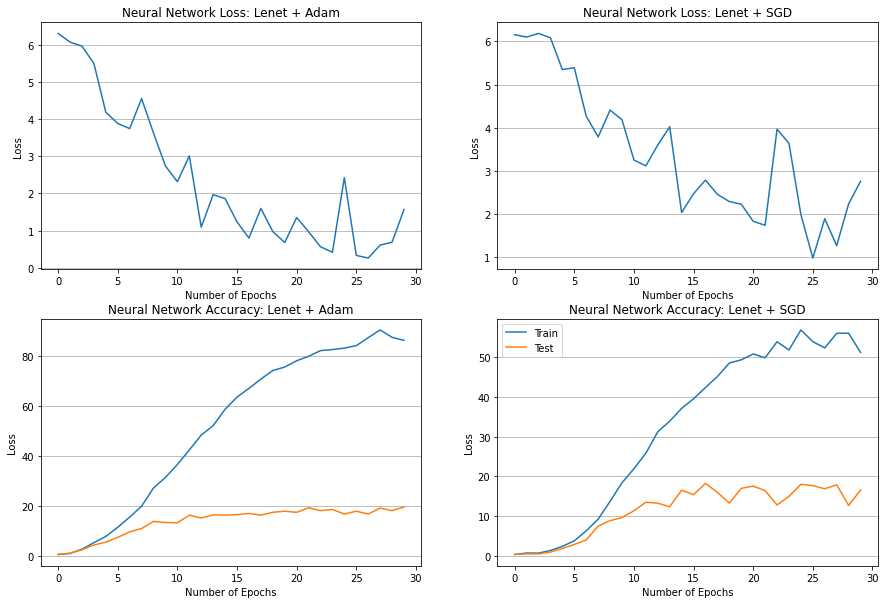

In [79]:
lenet_fig, lenet_axs = plt.subplots(2, 2, figsize=(15, 10))
lenet_axs[0,0].plot(list(map(lambda x: x[-1], lenet_loss_history_1)))
lenet_axs[0,0].grid(axis='y')
lenet_axs[0,0].set_title("Neural Network Loss: Lenet + Adam")    
lenet_axs[0,0].set_xlabel("Number of Epochs")
lenet_axs[0,0].set_ylabel("Loss")
# ax1.show()

lenet_axs[0,1].plot(list(map(lambda x: x[-1], lenet_loss_history_2)))
lenet_axs[0,1].grid(axis='y')
lenet_axs[0,1].set_title("Neural Network Loss: Lenet + SGD")    
lenet_axs[0,1].set_xlabel("Number of Epochs")
lenet_axs[0,1].set_ylabel("Loss")
# ax2.show()

lenet_axs[1,0].plot(list(map(lambda x: float(x), lenet_train_acc_history_1)), label="Train")
lenet_axs[1,0].plot(list(map(lambda x: float(x), lenet_test_acc_history_1)), label="Test")
lenet_axs[1,0].grid(axis='y')
lenet_axs[1,0].set_title("Neural Network Accuracy: Lenet + Adam")    
lenet_axs[1,0].set_xlabel("Number of Epochs")
lenet_axs[1,0].set_ylabel("Loss")
lenet_axs[1,0].legend()

lenet_axs[1,1].plot(list(map(lambda x: float(x), lenet_train_acc_history_2)), label="Train")
lenet_axs[1,1].plot(list(map(lambda x: float(x), lenet_test_acc_history_2)), label="Test")
lenet_axs[1,1].grid(axis='y')
lenet_axs[1,1].set_title("Neural Network Accuracy: Lenet + SGD")    
lenet_axs[1,1].set_xlabel("Number of Epochs")
lenet_axs[1,1].set_ylabel("Loss")
lenet_axs[1,1].legend()

lenet_accuracy_1 = evaluate(lenet_1, test_loader)
print(f"Lenet + Adam Final accuracy = {lenet_accuracy_1 / len(test_dataset)*100:.2f}%")
lenet_accuracy_2 = evaluate(lenet_2, test_loader)
print(f"Lenet + SGD Final accuracy = {lenet_accuracy_2 / len(test_dataset)*100:.2f}%")

<br><span style="color:black;font-size:35px">**VGG16**</span>

In [14]:
vgg_learning_rate = 1e-2
vgg_nepochs = 20
vgg_batch_size = 32

vgg_transform = T.Compose([T.Resize(size=(32,32)), 
                            T.RandomHorizontalFlip(), 
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])])

loss_function = nn.CrossEntropyLoss()

In [15]:
# Split dataset into train and test sets
vgg_fish_data = QutFishDataset(data_path=data_path, transform=vgg_transform)
vgg_train_size = int(0.8 * len(fish_data))
vgg_test_size = len(fish_data) - train_size
vgg_train_dataset, vgg_test_dataset = random_split(vgg_fish_data, [vgg_train_size, vgg_test_size])
print(len(vgg_train_dataset))
print(len(vgg_test_dataset))

3528
883


In [16]:
# train and test loader
vgg_train_loader = DataLoader(vgg_train_dataset, batch_size=vgg_batch_size, shuffle=True)
vgg_test_loader = DataLoader(vgg_test_dataset, batch_size=vgg_batch_size, shuffle=False)
print(len(vgg_train_loader))

111


In [24]:
vgg = VGG16(hidden_features=512, nout=num_classes, dropout=False).to(device)
# print(vgg)

vgg_optimizer_sgd = optim.SGD(vgg.parameters(), lr=vgg_learning_rate)

loss_function = nn.CrossEntropyLoss()

vgg.train()
vgg_loss_history = []
vgg_train_acc_history = []
vgg_test_acc_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=vgg, 
                                        train_data=train_loader, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_optimizer_sgd))
    vgg_loss_history.append(loss_history)
    vgg_train_acc_history.append(accuracy)
    vgg_test_acc_history.append((evaluate(vgg, test_loader) / len(test_dataset)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {vgg_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(vgg_train_acc_history[-1])} test acc: {float(vgg_test_acc_history[-1])}")

Epoch:   5%|███▋                                                                     | 1/20 [00:13<04:09, 13.12s/epoch]

Epoch 0:
train loss: 6.747262477874756
train acc:  1.0770975351333618 test acc: 1.5855038166046143


Epoch:  10%|███████▎                                                                 | 2/20 [00:26<04:01, 13.41s/epoch]

Epoch 1:
train loss: 5.225175380706787
train acc:  3.0328798294067383 test acc: 2.944507360458374


Epoch:  15%|██████████▉                                                              | 3/20 [00:40<03:53, 13.72s/epoch]

Epoch 2:
train loss: 4.459995269775391
train acc:  6.405895709991455 test acc: 4.530011177062988


Epoch:  20%|██████████████▌                                                          | 4/20 [00:54<03:37, 13.57s/epoch]

Epoch 3:
train loss: 4.899972915649414
train acc:  10.005668640136719 test acc: 6.795016765594482


Epoch:  25%|██████████████████▎                                                      | 5/20 [01:07<03:22, 13.47s/epoch]

Epoch 4:
train loss: 2.723236560821533
train acc:  15.391157150268555 test acc: 9.173272132873535


Epoch:  30%|█████████████████████▉                                                   | 6/20 [01:20<03:08, 13.47s/epoch]

Epoch 5:
train loss: 2.419525384902954
train acc:  21.201814651489258 test acc: 13.703283309936523


Epoch:  35%|█████████████████████████▌                                               | 7/20 [01:34<02:56, 13.56s/epoch]

Epoch 6:
train loss: 3.5463831424713135
train acc:  27.551021575927734 test acc: 11.778029441833496


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [01:48<02:42, 13.53s/epoch]

Epoch 7:
train loss: 2.993950128555298
train acc:  34.89229202270508 test acc: 16.42129135131836


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [02:01<02:27, 13.41s/epoch]

Epoch 8:
train loss: 1.6135988235473633
train acc:  41.89342498779297 test acc: 20.61155128479004


Epoch:  50%|████████████████████████████████████                                    | 10/20 [02:15<02:16, 13.63s/epoch]

Epoch 9:
train loss: 2.2446200847625732
train acc:  48.55442428588867 test acc: 23.103055953979492


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [02:28<02:01, 13.53s/epoch]

Epoch 10:
train loss: 2.6722254753112793
train acc:  55.6689338684082 test acc: 25.02831268310547


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [02:41<01:47, 13.44s/epoch]

Epoch 11:
train loss: 1.2994722127914429
train acc:  61.479591369628906 test acc: 26.840316772460938


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [02:55<01:33, 13.41s/epoch]

Epoch 12:
train loss: 0.8501108884811401
train acc:  68.84920501708984 test acc: 26.61381721496582


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [03:08<01:20, 13.38s/epoch]

Epoch 13:
train loss: 0.6101729273796082
train acc:  74.31973266601562 test acc: 26.38731575012207


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [03:22<01:07, 13.43s/epoch]

Epoch 14:
train loss: 1.6009447574615479
train acc:  77.23922729492188 test acc: 27.746318817138672


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [03:35<00:53, 13.40s/epoch]

Epoch 15:
train loss: 1.3834806680679321
train acc:  80.95238494873047 test acc: 25.594562530517578


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [03:49<00:40, 13.49s/epoch]

Epoch 16:
train loss: 0.5918816924095154
train acc:  84.89228820800781 test acc: 29.558320999145508


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [04:02<00:26, 13.42s/epoch]

Epoch 17:
train loss: 0.5647713541984558
train acc:  87.6700668334961 test acc: 30.57757568359375


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [04:15<00:13, 13.46s/epoch]

Epoch 18:
train loss: 0.05182453989982605
train acc:  89.56916046142578 test acc: 33.97508239746094


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.48s/epoch]

Epoch 19:
train loss: 0.2729041278362274
train acc:  92.37528228759766 test acc: 33.74858474731445


In [47]:
vgg_drp = VGG16(hidden_features=512, nout=num_classes, dropout=True).to(device)
# print(vgg)

vgg_drp_optimizer_sgd = optim.SGD(vgg_drp.parameters(), lr=vgg_learning_rate)

vgg_drp.train()
vgg_drp_loss_history = []
vgg_drp_train_acc_history = []
vgg_drp_test_acc_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=vgg_drp, 
                                        train_data=train_loader, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_drp_optimizer_sgd))
    vgg_drp_loss_history.append(loss_history)
    vgg_drp_train_acc_history.append(accuracy)
    vgg_drp_test_acc_history.append((evaluate(vgg_drp, test_loader) / len(test_dataset)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {vgg_drp_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(vgg_drp_train_acc_history[-1])} test acc: {float(vgg_drp_test_acc_history[-1])}")

Epoch:   5%|███▋                                                                     | 1/20 [00:13<04:17, 13.53s/epoch]

Epoch 0:
train loss: 6.237982749938965
train acc:  0.36848074197769165 test acc: 0.6795017123222351


Epoch:  10%|███████▎                                                                 | 2/20 [00:27<04:09, 13.88s/epoch]

Epoch 1:
train loss: 6.275821685791016
train acc:  0.566893458366394 test acc: 1.3590034246444702


Epoch:  15%|██████████▉                                                              | 3/20 [00:41<03:53, 13.72s/epoch]

Epoch 2:
train loss: 5.931724548339844
train acc:  1.133786916732788 test acc: 2.1517553329467773


Epoch:  20%|██████████████▌                                                          | 4/20 [00:54<03:37, 13.57s/epoch]

Epoch 3:
train loss: 5.940964698791504
train acc:  1.5873016119003296 test acc: 2.944507360458374


Epoch:  25%|██████████████████▎                                                      | 5/20 [01:07<03:21, 13.47s/epoch]

Epoch 4:
train loss: 5.9701690673828125
train acc:  2.0691609382629395 test acc: 2.831256866455078


Epoch:  30%|█████████████████████▉                                                   | 6/20 [01:21<03:09, 13.51s/epoch]

Epoch 5:
train loss: 5.785643100738525
train acc:  2.8344671726226807 test acc: 4.077010154724121


Epoch:  35%|█████████████████████████▌                                               | 7/20 [01:34<02:55, 13.50s/epoch]

Epoch 6:
train loss: 5.0221052169799805
train acc:  3.6564626693725586 test acc: 4.077010154724121


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [01:48<02:42, 13.53s/epoch]

Epoch 7:
train loss: 5.3978071212768555
train acc:  5.1587300300598145 test acc: 5.436013698577881


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [02:02<02:30, 13.70s/epoch]

Epoch 8:
train loss: 5.389779090881348
train acc:  5.753968238830566 test acc: 6.908267021179199


Epoch:  50%|████████████████████████████████████                                    | 10/20 [02:15<02:16, 13.61s/epoch]

Epoch 9:
train loss: 5.03680419921875
train acc:  8.106575965881348 test acc: 8.493770599365234


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [02:29<02:02, 13.56s/epoch]

Epoch 10:
train loss: 5.620993614196777
train acc:  8.758503913879395 test acc: 8.60702133178711


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [02:42<01:48, 13.53s/epoch]

Epoch 11:
train loss: 4.926913738250732
train acc:  11.678004264831543 test acc: 10.532276153564453


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [02:56<01:34, 13.51s/epoch]

Epoch 12:
train loss: 3.9941272735595703
train acc:  13.775510787963867 test acc: 10.872027397155762


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [03:09<01:20, 13.47s/epoch]

Epoch 13:
train loss: 2.92386794090271
train acc:  16.581632614135742 test acc: 11.664778709411621


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [03:23<01:07, 13.48s/epoch]

Epoch 14:
train loss: 3.5315122604370117
train acc:  18.225624084472656 test acc: 16.76104164123535


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [03:36<00:53, 13.46s/epoch]

Epoch 15:
train loss: 3.3204336166381836
train acc:  21.8820858001709 test acc: 17.78029441833496


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [03:50<00:40, 13.44s/epoch]

Epoch 16:
train loss: 3.051091194152832
train acc:  25.538549423217773 test acc: 17.78029441833496


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [04:03<00:26, 13.46s/epoch]

Epoch 17:
train loss: 4.259647846221924
train acc:  27.324262619018555 test acc: 15.855039596557617


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [04:17<00:13, 13.47s/epoch]

Epoch 18:
train loss: 2.8348135948181152
train acc:  31.490930557250977 test acc: 19.479047775268555


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [04:30<00:00, 13.52s/epoch]

Epoch 19:
train loss: 2.6494598388671875
train acc:  36.11111068725586 test acc: 20.498300552368164


VGG16 Final accuracy = 33.75%
VGG16 (Dropout) Final accuracy = 20.50%


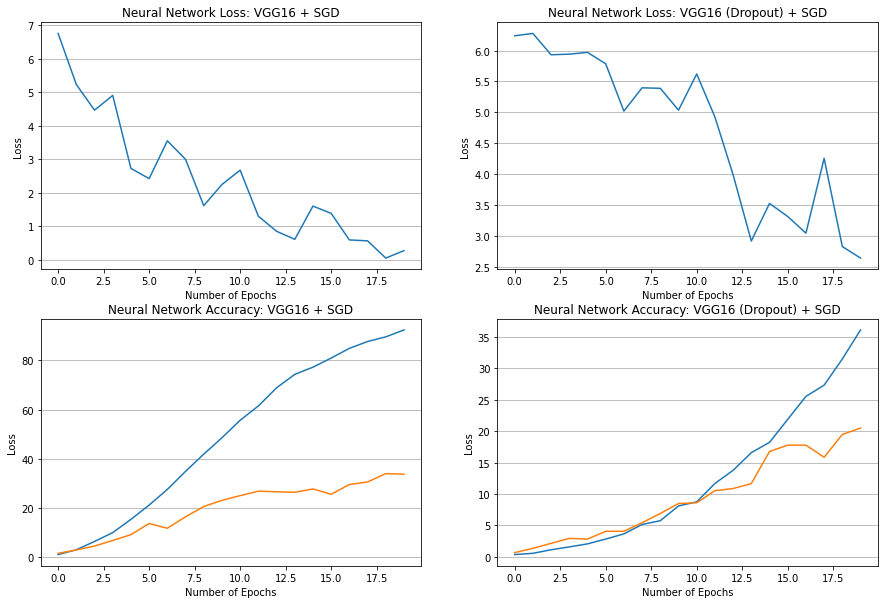

In [48]:
vgg_fig, vgg_axs = plt.subplots(2, 2, figsize=(15, 10))
vgg_axs[0,0].plot(list(map(lambda x: x[-1], vgg_loss_history)))
vgg_axs[0,0].grid(axis='y')
vgg_axs[0,0].set_title("Neural Network Loss: VGG16 + SGD")    
vgg_axs[0,0].set_xlabel("Number of Epochs")
vgg_axs[0,0].set_ylabel("Loss")
# ax1.show()

vgg_axs[0,1].plot(list(map(lambda x: x[-1], vgg_drp_loss_history)))
vgg_axs[0,1].grid(axis='y')
vgg_axs[0,1].set_title("Neural Network Loss: VGG16 (Dropout) + SGD")    
vgg_axs[0,1].set_xlabel("Number of Epochs")
vgg_axs[0,1].set_ylabel("Loss")
# ax2.show()

vgg_axs[1,0].plot(list(map(lambda x: float(x), vgg_train_acc_history)), label="Train")
vgg_axs[1,0].plot(list(map(lambda x: float(x), vgg_test_acc_history)), label="Test")
vgg_axs[1,0].grid(axis='y')
vgg_axs[1,0].set_title("Neural Network Accuracy: VGG16 + SGD")    
vgg_axs[1,0].set_xlabel("Number of Epochs")
vgg_axs[1,0].set_ylabel("Loss")

vgg_axs[1,1].plot(list(map(lambda x: float(x), vgg_drp_train_acc_history)), label="Train")
vgg_axs[1,1].plot(list(map(lambda x: float(x), vgg_drp_test_acc_history)), label="Test")
vgg_axs[1,1].grid(axis='y')
vgg_axs[1,1].set_title("Neural Network Accuracy: VGG16 (Dropout) + SGD")    
vgg_axs[1,1].set_xlabel("Number of Epochs")
vgg_axs[1,1].set_ylabel("Loss")

vgg_accuracy = evaluate(vgg, test_loader)
print(f"VGG16 Final accuracy = {vgg_accuracy / len(test_dataset)*100:.2f}%")
vgg_drp_accuracy = evaluate(vgg_drp, test_loader)
print(f"VGG16 (Dropout) Final accuracy = {vgg_drp_accuracy / len(test_dataset)*100:.2f}%")

<br><span style="color:black;font-size:35px">**AlexNet**</span>

In [17]:
alex_transform = T.Compose([T.Resize(size=(224, 224)),
                            T.CenterCrop(224),
                            T.RandomHorizontalFlip(),
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                           ])

alex_fish_data = QutFishDataset(data_path=data_path, transform=alex_transform)
alex_train_size = int(0.8 * len(alex_fish_data))
alex_test_size = len(alex_fish_data) - alex_train_size
alex_train_dataset, alex_test_dataset = random_split(alex_fish_data, [alex_train_size, alex_test_size])
print(len(alex_train_dataset))
print(len(alex_test_dataset))

3528
883


In [18]:
alex_learning_rate = 1e-3
alex_batch_size = 10
alex_momentum = 0.9
alex_nepochs = 5

alex_train_loader = DataLoader(alex_train_dataset, batch_size=alex_batch_size, shuffle=True, num_workers=2)
alex_test_loader = DataLoader(alex_test_dataset, batch_size=alex_batch_size, shuffle=False, num_workers=2)
print(len(alex_train_loader))
print(len(alex_test_loader))

353
89


In [ ]:
# alex = AlexNet(nout=num_classes).to(device)
alex = torch.hub.load("pytorch/vision:v0.6.0", "alexnet", pretrained=True)
alex.classifier[4] = nn.Linear(4096, 1024)
alex.classifier[6] = nn.Linear(1024, num_classes)
alex = alex.to(device)
# alex.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Sigmoid())
print(alex)

alex_optimizer_sgd = optim.SGD(alex.parameters(), lr=alex_learning_rate)

alex_loss_function = nn.CrossEntropyLoss()

alex.train()
alex_loss_history = []
alex_train_acc_history = []
alex_test_acc_history = []
for epoch in tqdm(range(alex_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=alex, 
                                        train_data=alex_train_loader, 
                                        LossFunction=alex_loss_function, 
                                        optimizer=alex_optimizer_sgd))
    alex_loss_history.append(loss_history)
    alex_train_acc_history.append(accuracy)
    alex_test_acc_history.append((evaluate(alex, alex_test_loader) / len(alex_test_dataset)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {alex_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(alex_train_acc_history[-1])} test acc: {float(alex_test_acc_history[-1])}")

Using cache found in C:\Users\Evant/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch:   0%|                                                                                  | 0/5 [00:00<?, ?epoch/s]